In [1]:
import os
import re
import glob
import bbi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.patches import Path, PathPatch, Rectangle
from matplotlib.collections import PatchCollection
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [2]:
def draw_bigwig(ax, bwfile, chrom, start, end, color, bins=100):
    track_patch = list()
    with bbi.open(bwfile) as f:
        data = f.fetch(chrom, start, end, bins)
        minx = np.min(data)
        maxx = np.max(data)
        for i, x in enumerate(data):
            startx = start + i * binsize
            track_rect = Rectangle([startx, 0], binsize, x, color=color)
            track_patch.append(track_rect)
    track_collection = PatchCollection(track_patch, match_original=True, edgecolors=color, facecolors=color)
    ax.add_collection(track_collection)
    ax.set_xlim((start, end))
    ax.set_ylim((minx, maxx))
    ax.get_xaxis().set_visible(False)

In [3]:
def draw_gene(ax, gff, chrom, start, end):
    gene_df = pd.read_csv(gff, sep="\t", comment="#", names=['chrom', 'source', 'type', 'start', 'end', 'skip1', 'strand', 'skip2', 'feature'])
    target_anno = gene_df[(gene_df['chrom'] == chrom) & (gene_df['start'] > start) & (gene_df['end'] < end)]
#     target_anno = gene_df[(gene_df['chrom'] == chrom) & ((gene_df['end'] < start) & (gene_df['end'] > start)) | ((gene_df['start'] < end) & (gene_df['end'] > end))]
    
    track_patch = list()
    for i, row in target_anno.iterrows():
        attribute = row.feature.rstrip(";").split(";")
#         attribute = [re.sub('"', '', x) for x in attribute]
        attribute = [x.split("=") for x in attribute]
        attribute = pd.DataFrame(attribute, columns=['attr', 'value'])
        geneInfo = dict(zip(attribute['attr'], attribute['value']))
        if row.type == 'exon':
            track_rect = Rectangle([row.start, 0.5], row.end-row.start, 0.4, color='blue')
            track_patch.append(track_rect)
        elif row.type == 'gene' and row.strand=='+':
#             plt.arrow(row.start, 0.5, row.end - row.start, 0, color='black', length_includes_head=False, shape='right')
            arrow = mpatches.FancyArrowPatch((row.start, 0.7), (row.end, 0.7), mutation_scale=10)
            ax.text((row.start + row.end)/2, 0.1, geneInfo['gene_name'])
            ax.add_patch(arrow)
        elif row.type == 'gene' and row.strand=='-':
#             plt.arrow(row.end, 0.5, row.start - row.end, 0, color='black', length_includes_head=False, shape='left')
            arrow = mpatches.FancyArrowPatch((row.end, 0.7), (row.start, 0.7), mutation_scale=10)
            ax.text((row.start + row.end)/2, 0.1, geneInfo['gene_name'])
            ax.add_patch(arrow)
    track_collection = PatchCollection(track_patch, match_original=True, edgecolors='blue', facecolors='blue')
    ax.add_collection(track_collection)
    ax.set_xlim((start, end))
    ax.set_ylim((0, 1))
    ax.get_yaxis().set_visible(False)

In [4]:
def draw_dmr(ax, dmrfile, chrom, start, end, celltype):
    dmr_df = pd.read_csv(dmrfile, sep="\t", names=['chrom', 'start', 'end', 'cell'])
    target_dmr = dmr_df[(dmr_df['cell'] == celltype) & (dmr_df['chrom'] == chrom) & (dmr_df['start'] > start) & (dmr_df['end'] < end)]
    
    track_patch = list()
    for i, row in target_dmr.iterrows():
        track_rect = Rectangle([row.start, 0.5], row.end-row.start+1, 0.4, color='blue')
        track_patch.append(track_rect)
    track_collection = PatchCollection(track_patch, match_original=True, edgecolors='blue', facecolors='blue')
    ax.add_collection(track_collection)
    ax.set_xlim((start, end))
    ax.set_ylim((0, 1))
    ax.get_yaxis().set_visible(False)

In [5]:
gff_file = "/gale/netapp/DoD/wenliang/database/ref/hg38/Annotation/gencode.v35.annotation.gff3"

In [6]:
dmr_file = '/gale/netapp/DoD/wenliang/projects/01.HIV/19.mergeCond/all_dmrs.bed'

## IFI44L

In [17]:
chrom = 'chr1'
start = 78621076
end = 78625831
binsize = 5
bins = (end - start +1) // binsize + 1
celltype='Tc-Mem'

In [18]:
bigwigs = sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/06.integration/03.snpaATAC/out/acute*{celltype}.bw"))\
        + sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/06.integration/03.snpaATAC/out/chronic*{celltype}.bw"))\
        + sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/06.integration/03.snpaATAC/out/pre*{celltype}.bw"))\
        + sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/19.mergeCond/bigwigs/acu*{celltype}*.frac.bw"))\
        + sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/19.mergeCond/bigwigs/cro*{celltype}*.frac.bw"))\
        + sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/19.mergeCond/bigwigs/pre*{celltype}*.frac.bw"))
bigwigs = [x for x in bigwigs if 'Other-cell' not in x]
cell_order = [re.sub("\.\S+", "", os.path.basename(x)) for x in bigwigs]

In [19]:
color_plate = sns.color_palette("tab20")
# color_plate = [color_plate[0]] * 9 + [color_plate[6]] * 9 + [color_plate[2]] * 9
color_plate = ['red', 'orange', 'blue', 'red', 'orange', 'blue']
cell2color = dict(zip(cell_order, color_plate[:len(cell_order)]))

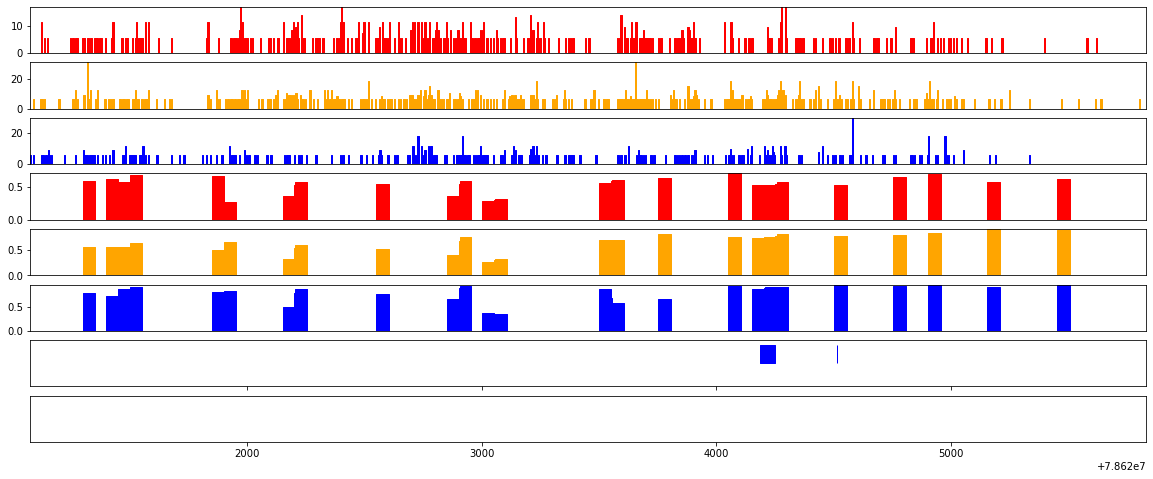

In [20]:
fig, axes = plt.subplots(len(bigwigs)+2,1, figsize=(20, len(bigwigs) +2), sharex=True)
for i, bigwig in enumerate(bigwigs):
    sampleID = re.sub("\.\S+", "", os.path.basename(bigwig))
    draw_bigwig(axes[i], bigwig, chrom, start, end, cell2color[sampleID], bins)
draw_dmr(axes[i+1], dmr_file, chrom, start, end, celltype)
draw_gene(axes[i+2], gff_file, chrom, start, end)
plt.savefig(f"{celltype}.IFI44L.pdf")

# DGKH

In [7]:
chrom = 'chr13'
start = 42052051
end = 42060012
binsize = 5
bins = (end - start +1) // binsize + 1
celltype = 'Tc-Mem'

In [8]:
bigwigs = sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/06.integration/03.snpaATAC/out/acute*{celltype}.bw"))\
        + sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/06.integration/03.snpaATAC/out/chronic*{celltype}.bw"))\
        + sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/06.integration/03.snpaATAC/out/pre*{celltype}.bw"))\
        + sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/19.mergeCond/bigwigs/acu*{celltype}*.frac.bw"))\
        + sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/19.mergeCond/bigwigs/cro*{celltype}*.frac.bw"))\
        + sorted(glob.glob(f"/gale/netapp/DoD/wenliang/projects/01.HIV/19.mergeCond/bigwigs/pre*{celltype}*.frac.bw"))
bigwigs = [x for x in bigwigs if 'Other-cell' not in x]
cell_order = [re.sub("\.\S+", "", os.path.basename(x)) for x in bigwigs]

In [9]:
# color_plate = ['red'] + ['orange'] + ['blue'] + ['red'] + ['orange'] + ['blue']
color_plate = ['#BE1E2D', '#F7941D', '#2BB673', '#BE1E2D', '#F7941D', '#2BB673']
cell2color = dict(zip(cell_order, color_plate[:len(cell_order)]))

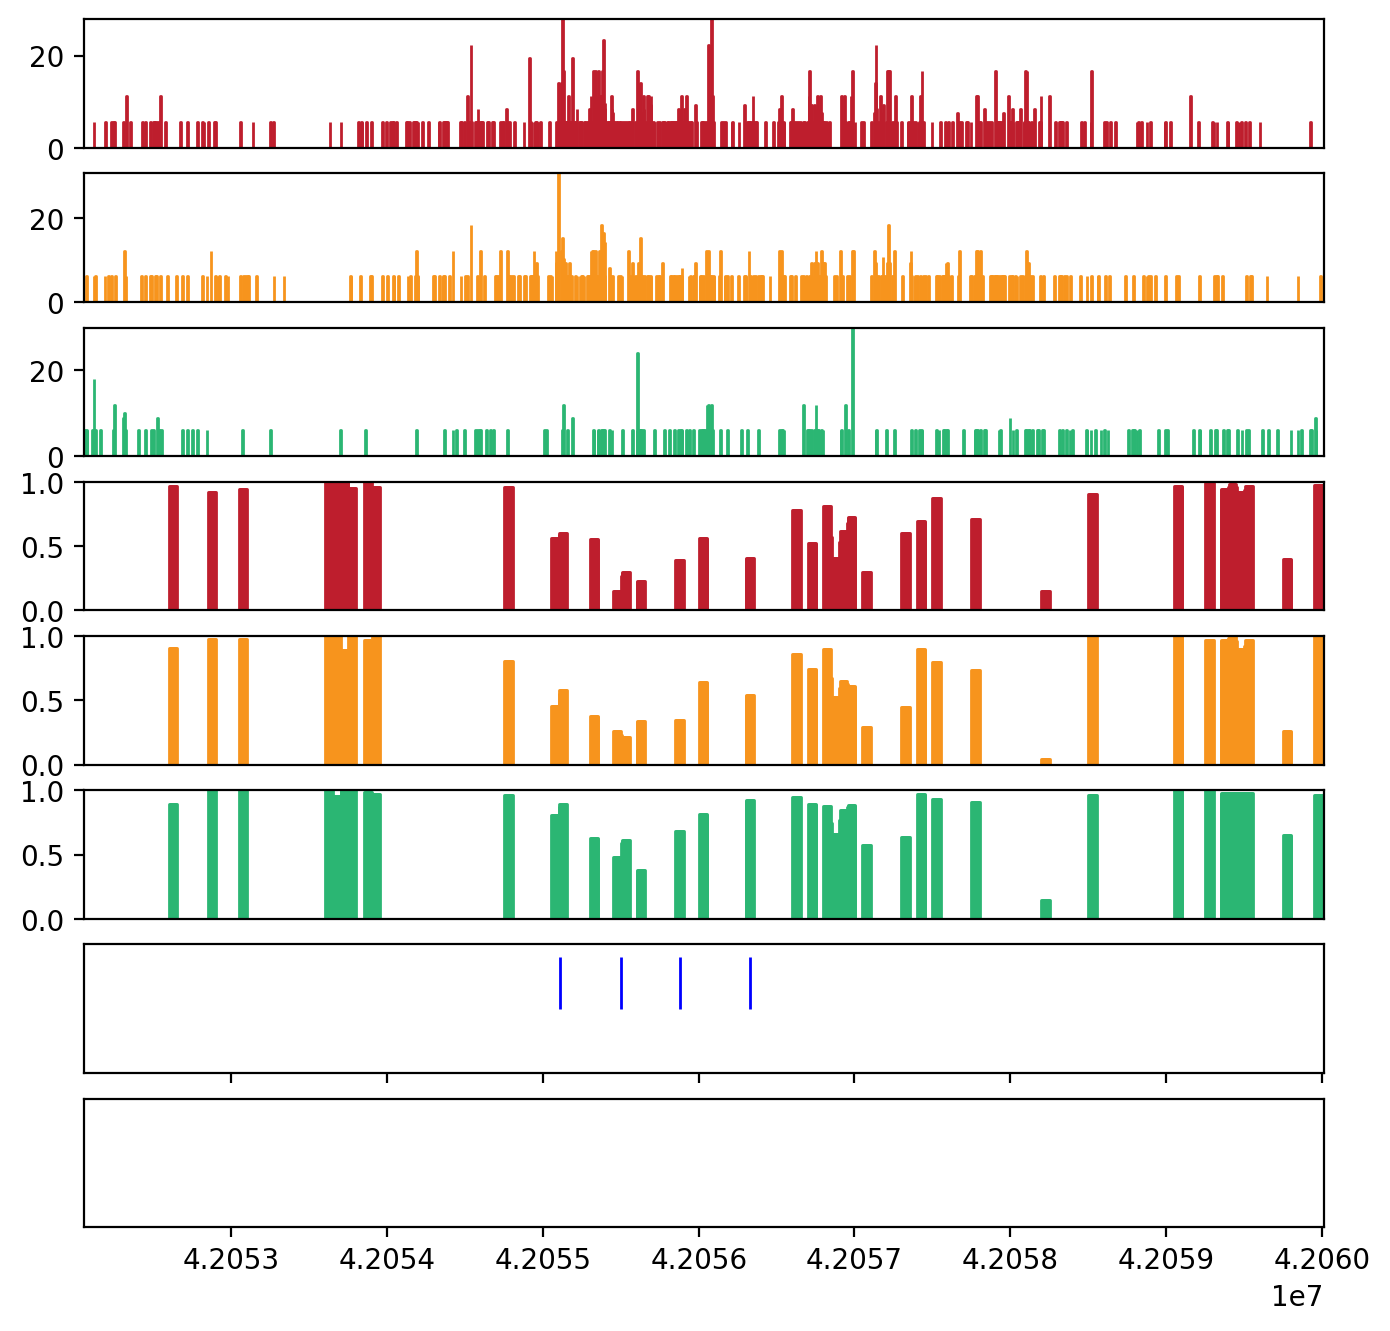

In [10]:
fig, axes = plt.subplots(len(bigwigs)+2,1, figsize=(8, len(bigwigs) +2), sharex=True, dpi=200)
for i, bigwig in enumerate(bigwigs):
    sampleID = re.sub("\.\S+", "", os.path.basename(bigwig))
    draw_bigwig(axes[i], bigwig, chrom, start, end, cell2color[sampleID], bins)

draw_dmr(axes[i+1], dmr_file, chrom, start, end, celltype)
draw_gene(axes[i+2], gff_file, chrom, start, end)
plt.savefig("Tc-Mem.DGKH.pdf")

## Tc-Mem sort by donor

In [61]:
color_plate = sns.color_palette("tab20")
cond2color = {'pre':color_plate[0], 'acu': color_plate[6], 'cro': color_plate[2]}

In [62]:
cond

'cro'

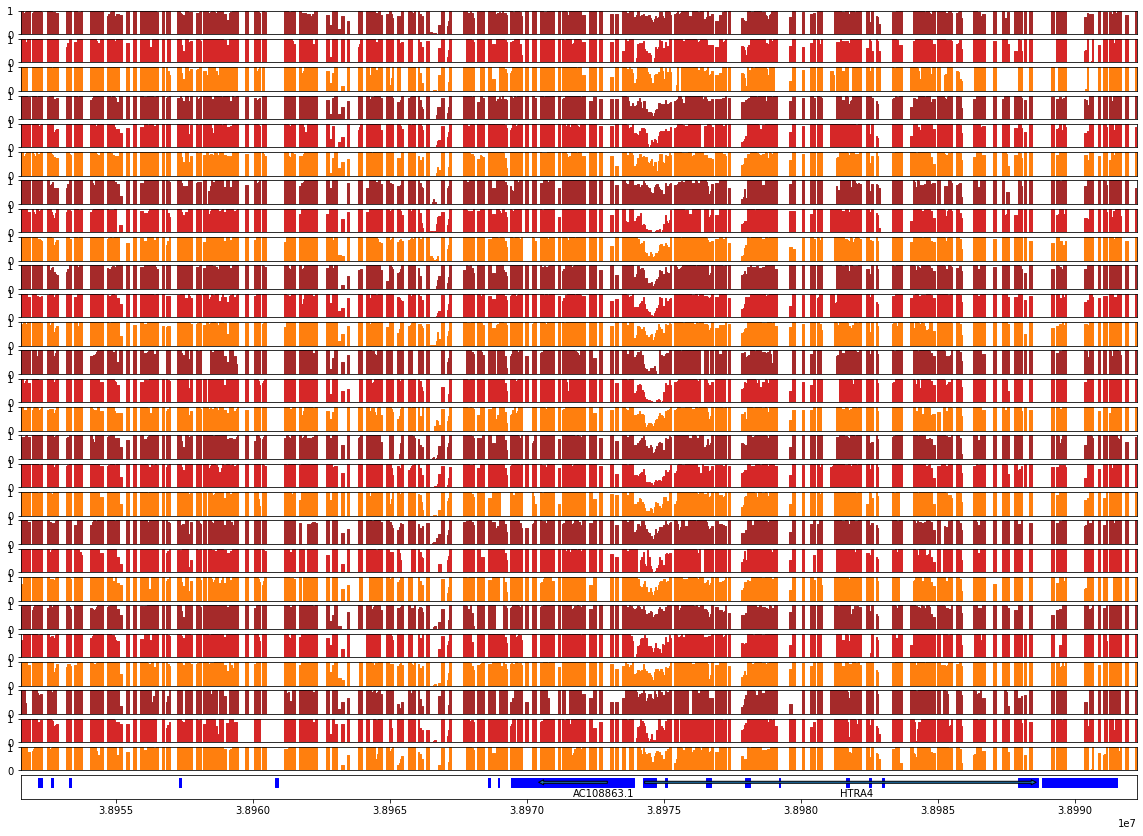

In [63]:
fig, axes = plt.subplots(27+1,1, figsize=(20, 27 * 0.5 +1), sharex=True)
i = 0
for donor in ['D' + str(x) for x in range(1,10)]:
    for cond in ['pre', 'acu', 'cro']:
        bigwig = glob.glob(f'/gale/netapp/DoD/wenliang/projects/01.HIV/08.MergeAllc/bigwig/{cond}_{donor}*Tc-Mem*.frac.bw')[0]
        draw_bigwig(axes[i], bigwig, chrom, start, end, cond2color[cond], bins)
        i += 1
draw_gene(axes[i], gff_file, chrom, start, end)